In [50]:
import pandas as pd
import re
import nltk
import itertools
import networkx as nx
import matplotlib.pyplot as plt

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/master/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

[reference blog](https://chaelist.github.io/docs/network_analysis/semantic_network/)

# 필터

In [40]:
# data load
# raw 데이터를 바꾸자!
raw = pd.read_excel('/Users/master/dev/PythonPr/NLP-visualization/data/korea medical-2023-04-04-result.xlsx')
raw = raw[['title', 'body', 'url']]

# text cleaning
raw['title'] = list(map(lambda x: re.sub('[^.,?!\s\w]','',x),raw['title']))
raw['body'] = list(map(lambda x: re.sub('[^.,?!\s\w]','',str(x)),raw['body']))

# case conversion
raw['title'] = list(map(lambda x: x.lower(), raw['title']))
raw['body'] = list(map(lambda x: x.lower(), raw['body']))

In [41]:
filtered_content = raw.copy()

# 토큰화

In [42]:
# Tokenization
full_body = ''.join(filtered_content['body'])
full_title = ''.join(filtered_content['title'])
full_text = ''.join([full_title, full_body])

word_tokens = nltk.word_tokenize(full_text)

# POS tagging
tokens_pos = nltk.pos_tag(word_tokens)

# select nouns
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)


In [43]:
# Lemmatization
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []

for word in NN_words:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [44]:
# Stopwords removal
# 1차적으로 nltk에서 제공하는 불용어사전을 이용해서 불용어를 제거
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') #nltk에서 제공하는 불용어사전 이용
unique_NN_words = set(lemmatized_words)   #set을 사용해 중복 제거
final_NN_words = lemmatized_words

for word in unique_NN_words:
    if word in stopwords_list:
        while word in final_NN_words: final_NN_words.remove(word)


# 아래와 같이 추가로 직접 만든 불용어사전을 이용해 불용어 제거
customized_stopwords = ['be', 'today', 'yesterday', 'new', 'york', 'time']  # 직접 만든 불용어 사전
unique_NN_words1 = set(final_NN_words)

for word in unique_NN_words1:
    if word in customized_stopwords:
        while word in final_NN_words: final_NN_words.remove(word)


## final_NN_words 출력해보기
print(final_NN_words)

['junior', 'ambassador', 'korea', 'device', 'market', 'company', 'cardiologist', 'lament', 'politics', 'effect', 'sectorkimes', 'device', 'night', 'sweat', 'flash', 'device', 'arthritis', 'patient', 'politics', 'quagmiretwo', 'trend', 'school', 'agent', 'proposes', 'malpractice', 'punishment', 'woman', 'leader', 'woman', 'biotech', 'matica', 'imaging', 'service', 'provider', 'radlink', 'software', 'market', 'news', 'growth', 'rate', 'return', 'tourism', 'korea', 'doctor', 'fee', 'system', 'tourism', 'competition', 'korea', 'cannabis', 'market', 'hospital', 'korea', 'ai', 'industry', 'flourish', 'part', 'itkorea', 'tourism', 'tourist', 'travel', 'korea', 'donates', 'worth', 'equipment', 'health', 'minister', 'head', 'call', 'school', 'enrollment', 'movement', 'opposition', 'rise', 'tourismdoctors', 'strike', 'legislation', 'nursing', 'actchosun', 'university', 'hospital', 'korea', 'clinichealth', 'ministry', 'push', 'student', 'quota', 'backlash', 'korea', 'surgeon', 'yungkyoonkorean', 

# Semantic Network 형성

In [45]:
# 단어 빈도 파악
# 최빈 10개 추출
from collections import Counter

c = Counter(final_NN_words)
print(c.most_common(15))   # 가장 빈번하게 나오는 10개의 단어 출력

# 가장 많이 나오는 단어 10개 저장
list_of_words = []
for word, count in c.most_common(15):
    list_of_words.append(word)
print(list_of_words)

[('korea', 330), ('patient', 244), ('health', 218), ('healthcare', 180), ('hospital', 175), ('year', 164), ('company', 155), ('data', 142), ('industry', 130), ('market', 124), ('country', 122), ('system', 120), ('treatment', 119), ('technology', 105), ('people', 105)]
['korea', 'patient', 'health', 'healthcare', 'hospital', 'year', 'company', 'data', 'industry', 'market', 'country', 'system', 'treatment', 'technology', 'people']


In [46]:
# 원본 text 문장 단위로 쪼개기
sentences = full_text.split('\n')

def sentence_divide(target_symbol):
    result = []
    for sentence in sentences:
        result.extend(sentence.split(target_symbol))
    return result
sentences = sentence_divide('. ')
sentences = sentence_divide('!')
article_sentences = sentence_divide('?')

In [47]:
G = nx.Graph()
G.add_nodes_from(list_of_words)

print(G.nodes())
print(G.edges())


['korea', 'patient', 'health', 'healthcare', 'hospital', 'year', 'company', 'data', 'industry', 'market', 'country', 'system', 'treatment', 'technology', 'people']
[]


In [48]:

for sentence in article_sentences:  # 각 문장을 element로 담고 있는 list
    sentence = sentence.lower()
    
    word_tokens = nltk.word_tokenize(sentence)
    tokens_pos = nltk.pos_tag(word_tokens)

    NN_words = []  
    for word, pos in tokens_pos:
        if 'NN' in pos:
            NN_words.append(word)

    wlem = nltk.WordNetLemmatizer()
    lemmatized_words = []
    for word in NN_words:
        new_word = wlem.lemmatize(word)
        lemmatized_words.append(new_word)
    
    selected_words = []
    for word in lemmatized_words:
        if word in list_of_words:
            selected_words.append(word)   # 빈도 top 10에 포함된 단어만 append
    
    selected_words = set(selected_words)   # 중복을 제거하기 위해 set(집합자료형)으로 변환
    

    for pair in list(itertools.combinations(list(selected_words), 2)):  
                    # itertools.combinations: selected_words 리스트에서 2개씩 골라 조합을 만들어준다
        if pair in G.edges(): 
            weight = G[pair[0]][pair[1]]['weight']
            weight += 1
            G[pair[0]][pair[1]]['weight'] = weight    
        else:
            G.add_edge(pair[0], pair[1], weight=1)


# 생성된 edge 확인해보기
print(nx.get_edge_attributes(G, 'weight'))

{('korea', 'market'): 27, ('korea', 'company'): 24, ('korea', 'system'): 31, ('korea', 'hospital'): 43, ('korea', 'health'): 59, ('korea', 'healthcare'): 45, ('korea', 'industry'): 47, ('korea', 'treatment'): 33, ('korea', 'country'): 39, ('korea', 'patient'): 51, ('korea', 'data'): 20, ('korea', 'year'): 36, ('korea', 'technology'): 18, ('korea', 'people'): 15, ('patient', 'market'): 8, ('patient', 'country'): 26, ('patient', 'company'): 13, ('patient', 'health'): 31, ('patient', 'healthcare'): 12, ('patient', 'system'): 23, ('patient', 'data'): 20, ('patient', 'industry'): 16, ('patient', 'year'): 27, ('patient', 'treatment'): 41, ('patient', 'hospital'): 34, ('patient', 'technology'): 17, ('patient', 'people'): 11, ('health', 'hospital'): 17, ('health', 'healthcare'): 30, ('health', 'industry'): 28, ('health', 'market'): 11, ('health', 'treatment'): 22, ('health', 'country'): 23, ('health', 'company'): 12, ('health', 'system'): 26, ('health', 'data'): 9, ('health', 'year'): 23, ('he

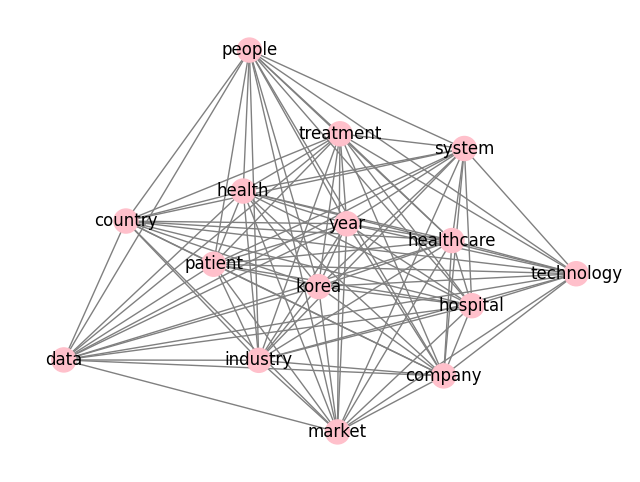

In [49]:

## 노드의 degree에 따라 color 다르게 설정하기
color_map = []
for node in G:
    if G.degree(node) >= 8:   # 중요한 노드 (degree가 8 이상)
        color_map.append('pink') 
    else: 
        color_map.append('beige')    

plt.figure(figsize=(8, 6))  # size 설정

pos = nx.spring_layout(G, scale=0.2)   # spring layout 사용, 글씨가 잘리는 것을 방지하기 위해 scale=0.2로 조정
nx.draw_networkx(G, pos, node_color=color_map, edge_color='grey')

plt.axis('off') # turn off axis 
plt.show()

In [52]:
raw.head()

,title,body,url
0,super juniors ryeowook appointed as honorary a...,medical korea 2023 kicked off on thursday desi...,https://news.google.com/articles/CBMiPWh0dHBzO...
1,"even if korean medical device market grows, fo...",although the korean medical device market grow...,https://news.google.com/articles/CBMiPWh0dHBzO...
2,top pediatric cardiologist laments politics il...,"former lawmaker park insook said so, describin...",https://news.google.com/articles/CBMiPWh0dHBzO...
3,kimes 2023 medical devices should be similar f...,with the korean biotech industry trying to lea...,https://news.google.com/articles/CBMiPWh0dHBzO...
4,night sweats? hot flashes? perimenopause more ...,middleaged women go through a lot of changes w...,https://news.google.com/articles/CBMiPWh0dHBzO...


In [54]:
raw.iloc[:,0]

0     super juniors ryeowook appointed as honorary a...
1     even if korean medical device market grows, fo...
2     top pediatric cardiologist laments politics il...
3     kimes 2023 medical devices should be similar f...
4     night sweats? hot flashes? perimenopause more ...
                            ...                        
80    weekly stock relay bidens biomanufacturing ini...
81    abbvies skyrizi expands insurance benefits for...
82    sharing a living dream with samsung bioepis, i...
83    medical robots global market report 2022 featu...
84    2023 jp morgan healthcare conference investors...
Name: title, Length: 85, dtype: object